# Base model choices

Yangkang Chen<br>
Jan 12, 2024

This notebook is to show 

1. how you could use other models of the `BaseEstimator` class of `sklearn` style as base model for `AdaSTEM` framework, and 
2. to compare the performance of different base models.

We tested the following algorithm:

- DecisionTree
- LightGBM
- XGBoost
- Stochastic gradient decent (SGD)
- Multi-layer perceptron (MLP)
- sklearn-GBM
- Ridge
- Random Forest (RF)
- Stacking of RF, XGB, and SGD


In [1]:
import pandas as pd
import numpy as np
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib
import warnings
import pickle
import os
import time

from stemflow.model.AdaSTEM import AdaSTEM, AdaSTEMClassifier, AdaSTEMRegressor
from stemflow.model.Hurdle import Hurdle_for_AdaSTEM, Hurdle
from stemflow.model_selection import ST_CV

from xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import SGDClassifier, SGDRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.linear_model import Ridge, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.ensemble import StackingClassifier, StackingRegressor, RandomForestClassifier, RandomForestRegressor

## The next two are not tested by could be passed as base model:
# from catboost import CatBoostClassifier, CatBoostRegressor
# from sklearn.linear_model import LogisticRegression, LinearRegression

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

## Download data

Please download the sample data from:<br>
- Mallard: https://figshare.com/articles/dataset/Sample_data_Mallard_csv/24080745<br>

Suppose now it's downloaded and saved as './Sample_data_Mallard.csv'<br>

Alternatively, you can try other species like <br>
- Alder Flycatcher: https://figshare.com/articles/dataset/Sample_data_Alder_Flycatcher_csv/24080751<br>
- Short-eared Owl: https://figshare.com/articles/dataset/Sample_data_Short-eared_Owl_csv/24080742<br>
- Eurasian Tree Sparrow: https://figshare.com/articles/dataset/Sample_data_Eurasian_Tree_Sparrow_csv/24080748<br>

**Caveat: These bird observation data are about 200MB each file.**

## Load data

In [51]:
data = pd.read_csv(f'./Sample_data_Mallard.csv')
data = data.drop('sampling_event_identifier', axis=1)

In [52]:
data.head()

,longitude,latitude,count,DOY,duration_minutes,Traveling,Stationary,Area,effort_distance_km,number_observers,obsvr_species_count,time_observation_started_minute_of_day,elevation_mean,slope_mean,eastness_mean,northness_mean,bio1,bio2,bio3,bio4,bio5,bio6,bio7,bio8,bio9,bio10,bio11,bio12,bio13,bio14,bio15,bio16,bio17,bio18,bio19,closed_shrublands,cropland_or_natural_vegetation_mosaics,croplands,deciduous_broadleaf_forests,deciduous_needleleaf_forests,evergreen_broadleaf_forests,evergreen_needleleaf_forests,grasslands,mixed_forests,non_vegetated_lands,open_shrublands,permanent_wetlands,savannas,urban_and_built_up_lands,water_bodies,woody_savannas,entropy
0,-83.472224,8.859308,0.0,22,300.0,1,0,0,4.828,5.0,34.0,476,7.555556,0.758156,0.036083,-0.021484,24.883502,5.174890,59.628088,93.482247,30.529131,21.850519,8.678612,24.302626,26.536822,26.213334,23.864924,0.720487,0.127594,0.003156,0.001451,0.332425,0.026401,0.044218,0.260672,0.0,0.000000,0.0,0.0,0.0,0.138889,0.000000,0.000000,0.000000,0.0,0.0,0.777778,0.000000,0.000000,0.083333,0.000000,0.676720
1,-2.687724,43.373323,9.0,290,90.0,1,0,0,0.570,2.0,151.0,1075,30.833336,3.376527,0.050544,-0.099299,14.107917,5.224109,31.174167,376.543853,23.219421,6.461607,16.757814,9.048385,19.092725,19.236082,9.287841,0.171423,0.035598,0.004512,0.000081,0.084657,0.018400,0.030210,0.065007,0.0,0.000000,0.0,0.0,0.0,0.333333,0.000000,0.000000,0.083333,0.0,0.0,0.000000,0.194444,0.027778,0.000000,0.361111,1.359063
2,-89.884770,35.087255,0.0,141,10.0,0,1,0,-1.000,2.0,678.0,575,91.777780,0.558100,-0.187924,-0.269078,17.396487,8.673912,28.688889,718.996078,32.948335,2.713938,30.234397,14.741099,13.759220,26.795849,7.747272,0.187089,0.031802,0.005878,0.000044,0.073328,0.026618,0.039616,0.059673,0.0,0.055556,0.0,0.0,0.0,0.000000,0.000000,0.305556,0.000000,0.0,0.0,0.000000,0.527778,0.000000,0.000000,0.111111,1.104278
3,-99.216873,31.218510,0.0,104,9.0,1,0,0,0.805,2.0,976.0,657,553.166700,0.856235,-0.347514,-0.342971,20.740836,10.665164,35.409121,666.796919,35.909941,5.790119,30.119822,18.444353,30.734456,29.546417,11.701038,0.084375,0.025289,0.000791,0.000052,0.052866,0.004096,0.006064,0.015965,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000
4,-124.426730,43.065847,2.0,96,30.0,1,0,0,0.161,2.0,654.0,600,6.500000,0.491816,-0.347794,-0.007017,11.822340,6.766870,35.672897,396.157833,22.608788,3.639569,18.969219,8.184412,16.290802,17.258721,7.319234,0.144122,0.044062,0.000211,0.000147,0.089238,0.004435,0.004822,0.040621,0.0,0.000000,0.0,0.0,0.0,0.361111,0.166667,0.000000,0.472222,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.020754


## Get X and y

In [12]:
def get_X_and_y(data):
    X = data.drop('count', axis=1)
    y = np.log(data['count'].values + 1)
    return X, y

X, y = get_X_and_y(data)

## Set up the set of candidate base models

In [145]:

base_model_dict = {
    'DecisionTree':{
        'classifier': DecisionTreeClassifier(random_state=42),
        'regressor': DecisionTreeRegressor(random_state=42)
    },
    'LightGBM':{
        'classifier': LGBMClassifier(n_jobs = 1, silent=True, random_state=42),
        'regressor': LGBMRegressor(n_jobs = 1, silent=True, random_state=42)
    },
    'XGBoost':{
        'classifier': XGBClassifier(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
        'regressor': XGBRegressor(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1)
    },
    'SGD':{
        'classifier': SGDClassifier(random_state=42),
        'regressor': SGDRegressor(random_state=42)
    },
    'MLP':{
        'classifier': MLPClassifier(random_state=42),
        'regressor': MLPRegressor(random_state=42)
    },
    'sklearn-GBM':{
        'classifier': GradientBoostingClassifier(random_state=42),
        'regressor': HistGradientBoostingRegressor(random_state=42)
    },
    'Ridge':{
        'classifier': Ridge(random_state=42),
        'regressor': RidgeClassifier(random_state=42)
    },
    'RF':{
        'classifier': RandomForestClassifier(random_state=42), 
        'regressor': RandomForestRegressor(random_state=42)
    },
    'Stacking_RF_XGB_SGD':{
        'classifier': StackingClassifier(estimators=[
                                    ('rf', RandomForestClassifier(random_state=42)),
                                    ('xgboost', XGBClassifier(random_state=42, n_jobs=1)),
                                    ('SGD', SGDClassifier(random_state=42))
                                ], final_estimator=DecisionTreeClassifier()),
        'regressor': StackingRegressor(estimators=[
                                    ('rf', RandomForestRegressor(random_state=42)),
                                    ('xgboost', XGBRegressor(random_state=42, n_jobs=1)),
                                    ('SGD', SGDRegressor(random_state=42))
                                ], final_estimator=DecisionTreeRegressor())
    }
}



## Model Training

Now we train `AdaSTEM` with each base model and 5-fold cross validation

At the same time, we record the training and testing time consumption for comparison:


In [ ]:
all_metric_list = []

for base_model_name in base_model_dict.keys():
    print(f'Training {base_model_name}')
    
    if os.path.exists(f'./Base_model_choices_metrics_{base_model_name}.csv'):
        metrics_for_base_model = pd.read_csv(f'./Base_model_choices_metrics_{base_model_name}.csv')
        all_metric_list.append(metrics_for_base_model)
        continue
    
    metrics_for_base_model = []
    
    # First thing first: Spatio-temporal train test split
    CV_generator = ST_CV(X, y,
                            Spatio_blocks_count = 50, Temporal_blocks_count=50,
                            CV=5)

    continue_training = True
    for cv_count, (X_train, X_test, y_train, y_test) in enumerate(CV_generator):
        
        if not continue_training:
            break
        
        # 1. Train AdaSTEM hurdle model
        model = AdaSTEMRegressor(
            base_model=Hurdle(
                classifier=base_model_dict[base_model_name]['classifier'],
                regressor=base_model_dict[base_model_name]['regressor']
            ),
            save_gridding_plot = True,
            ensemble_fold=10, 
            min_ensemble_required=7,
            grid_len_upper_threshold=25,
            grid_len_lower_threshold=5,
            points_lower_threshold=50,
            Spatio1='longitude',
            Spatio2 = 'latitude', 
            Temporal1 = 'DOY',
            use_temporal_to_train=True,
            n_jobs=1                       
        )
        
        start_t = time.time()
        
        ## fit adastem
        model.fit(X_train.reset_index(drop=True), y_train, verbosity=0)

        end_t = time.time()
        training_time = end_t - start_t
        
        if training_time>3600 * 2: # Stop training if timeout
            continue_training = False
            break
        
        # Evaluation
        start_t = time.time()
        pred_adastem = model.predict(X_test, verbosity=0)
        end_t = time.time()
        prediction_time = end_t - start_t
        
        perc = np.sum(np.isnan(pred_adastem.flatten()))/len(pred_adastem.flatten())
        print(f'Model {base_model_name}, CV {cv_count}: AdaSTEM percentage not predictable {round(perc*100, 2)}%')

        # 3. save metrics
        pred_df = pd.DataFrame({
            'y_true':y_test.flatten(),
            'y_pred_adastem':np.where(pred_adastem.flatten()<0, 0, pred_adastem.flatten()),
        }).dropna()
        
        ## 3.1 adastem metrics
        metric_dict = AdaSTEM.eval_STEM_res('hurdle', pred_df.y_true, pred_df.y_pred_adastem)
        metric_dict['X_train_size'] = X_train.shape[0]
        metric_dict['CV'] = cv_count
        metric_dict['perc_not_predictable'] = perc
        metric_dict['model'] = base_model_name
        metric_dict['Training_time'] = training_time
        metric_dict['Prediction_time'] = prediction_time
        metrics_for_base_model.append(metric_dict.copy())
        print(metric_dict)
        print()
        
    if not continue_training:
        continue
    
    metrics_for_base_model = pd.DataFrame(metrics_for_base_model)
    metrics_for_base_model.to_csv(f'./Base_model_choices_metrics_{base_model_name}.csv', index=False)
    
    all_metric_list.append(metrics_for_base_model)
        
    
    

Collect and save the metrics:

In [ ]:
all_metric_df = pd.concat(all_metric_list, axis=0).reset_index(drop=False)
all_metric_df.to_csv('./Base_model_choices_metrics_all.csv',index=False)


It looks like this:

In [148]:
all_metric_df

,index,AUC,kappa,f1,precision,recall,average_precision,Spearman_r,Pearson_r,R2,MAE,MSE,poisson_deviance_explained,X_train_size,CV,perc_not_predictable,model,Training_time,Prediction_time
0,0,0.676927,0.164754,0.395370,0.248309,0.969639,0.246035,0.395031,0.205585,-1.402543e-01,5.695269e+00,1.869304e+03,2.036257e-01,318477,0,0.030740,DecisionTree,638.341520,36.681800
1,1,0.677097,0.164519,0.394620,0.247707,0.969800,0.245447,0.398250,0.084485,-4.542523e-02,5.705932e+00,6.728450e+03,2.012030e-01,317082,1,0.034444,DecisionTree,620.482282,35.525578
2,2,0.688156,0.177700,0.400270,0.252591,0.963710,0.249623,0.399074,0.225947,-2.556107e-01,5.408951e+00,1.235143e+03,2.150856e-01,323313,2,0.038598,DecisionTree,652.088356,35.994669
3,3,0.681695,0.168434,0.393946,0.247317,0.967639,0.244823,0.392326,0.131813,-2.031915e-01,5.812655e+00,2.654513e+03,2.208657e-01,319430,3,0.038066,DecisionTree,639.186853,38.188345
4,4,0.679391,0.169062,0.399731,0.251806,0.968939,0.249417,0.399125,0.103436,-5.868983e-02,5.919508e+00,4.524786e+03,1.783509e-01,321708,4,0.035866,DecisionTree,650.174912,36.997543
5,0,0.768827,0.407247,0.532626,0.414465,0.745030,0.350756,0.475785,0.101214,9.246930e-03,3.898546e+00,5.738770e+03,1.217043e-01,319636,0,0.041698,LightGBM,1130.802027,58.145997
6,1,0.756345,0.392854,0.530542,0.414509,0.736789,0.352042,0.464358,0.238286,5.250629e-02,4.034458e+00,1.463341e+03,2.244589e-01,318385,1,0.036831,LightGBM,1113.431455,63.403299
7,2,0.763330,0.395678,0.528162,0.408248,0.747817,0.348028,0.466966,0.285535,8.097991e-02,4.160880e+00,1.917779e+03,2.744931e-01,321153,2,0.039887,LightGBM,1129.783578,62.615917
8,3,0.761117,0.397418,0.533785,0.415263,0.746985,0.354740,0.467409,0.198142,3.140337e-02,4.304510e+00,1.636159e+03,1.955495e-01,319715,3,0.037828,LightGBM,1105.956876,57.119682
9,4,0.760613,0.395195,0.534253,0.414336,0.751852,0.355768,0.468287,0.161192,2.562741e-02,4.196101e+00,3.954419e+03,2.045286e-01,321163,4,0.039677,LightGBM,1101.975057,62.806188


## Plotting metrics

We then create dataframe for plotting:

In [149]:
new_all_metric_df = []
for index,line in all_metric_df.iterrows():
    for me in ['AUC', 'kappa', 'f1', 'precision', 'recall',
       'average_precision', 'Spearman_r', 'Pearson_r', 'R2', 'MAE', 'MSE']:
        new_all_metric_df.append({
            'model':line['model'],
            'CV':line['CV'],
            'Training_time':line['Training_time'],
            'Prediction_time':line['Prediction_time'],
            'perc_not_predictable':line['perc_not_predictable'],
            'X_train_size':line['X_train_size'],
            'metric_name':me,
            'value':line[me]
        })
new_all_metric_df = pd.DataFrame(new_all_metric_df)


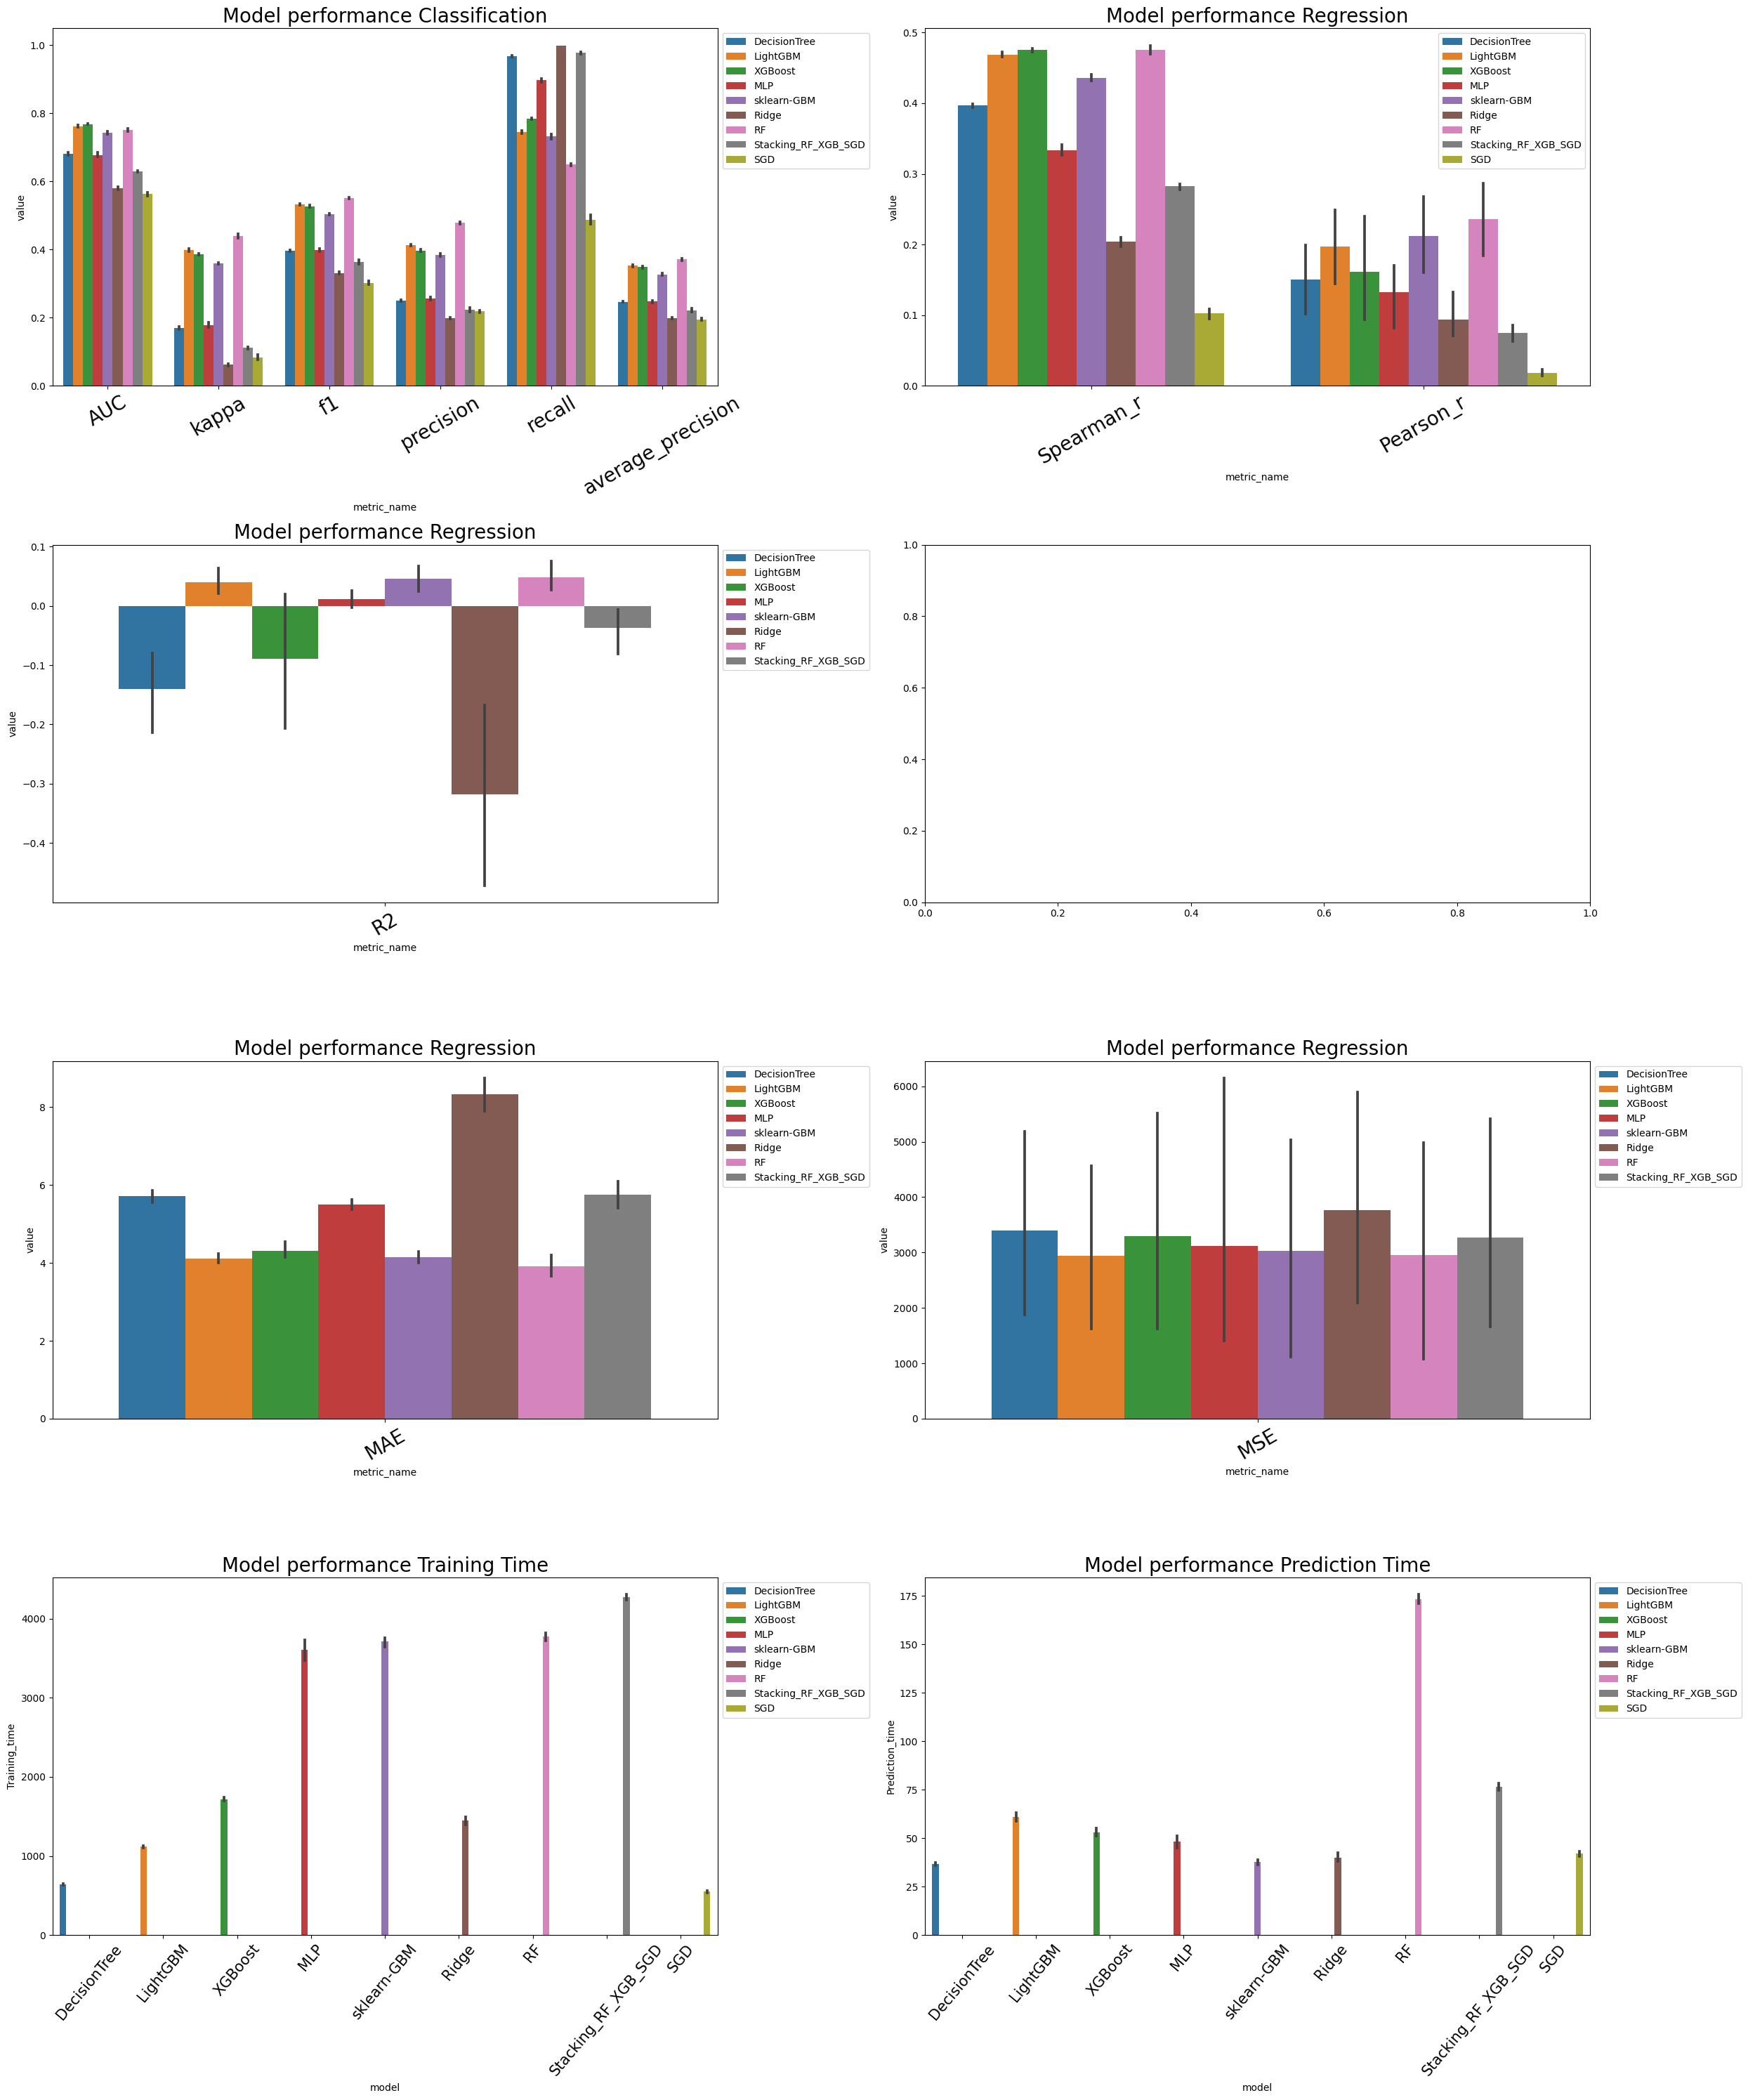

In [167]:
import seaborn as sns
dat_for_plot = new_all_metric_df
dat_for_plot = pd.concat([
    dat_for_plot[~dat_for_plot.model.isin(['SGD'])],
    dat_for_plot[dat_for_plot.model.isin(['SGD'])]
], axis=0)


# plot
fig, ax = plt.subplots(4, 2, figsize=(25,30), gridspec_kw={'width_ratios': [2, 2]})

### classification
plt.sca(ax[0,0])
sns.barplot(data=dat_for_plot[
        dat_for_plot.metric_name.isin(['AUC', 'kappa', 'f1', 'precision', 'recall', 'average_precision'])
    ], ci=95, 
            x="metric_name", y="value", hue="model")
plt.legend(bbox_to_anchor=(1,1))
plt.xticks(rotation=30,fontsize=20)
plt.title('Model performance Classification',fontsize=20)



## reg
plt.sca(ax[0,1])
sns.barplot(data=dat_for_plot[~dat_for_plot.model.isin([])][
        dat_for_plot.metric_name.isin(['Spearman_r', 'Pearson_r', 'poisson_deviance_explained'])
    ], ci=95, 
            x="metric_name", y="value", hue="model")
plt.legend(bbox_to_anchor=(1,1))
plt.xticks(rotation=30,fontsize=20)
plt.title('Model performance Regression',fontsize=20)



## reg
plt.sca(ax[1,0])
sns.barplot(data=dat_for_plot[~dat_for_plot.model.isin(['SGD'])][
        dat_for_plot.metric_name.isin(['R2'])
    ], ci=95, 
            x="metric_name", y="value", hue="model")
plt.legend(bbox_to_anchor=(1,1))
plt.xticks(rotation=30,fontsize=20)
plt.title('Model performance Regression',fontsize=20)



## reg
plt.sca(ax[2,0])
sns.barplot(data=dat_for_plot[~dat_for_plot.model.isin(['SGD'])][
        dat_for_plot.metric_name.isin(['MAE'])
    ], ci=95, 
            x="metric_name", y="value", hue="model")
plt.legend(bbox_to_anchor=(1,1))
plt.xticks(rotation=30,fontsize=20)
plt.title('Model performance Regression',fontsize=20)


## reg
plt.sca(ax[2,1])
sns.barplot(data=dat_for_plot[~dat_for_plot.model.isin(['SGD'])][
        dat_for_plot.metric_name.isin(['MSE'])
    ], ci=95, 
            x="metric_name", y="value", hue="model")
plt.title('Model performance Regression',fontsize=20)
plt.legend(bbox_to_anchor=(1,1))
plt.xticks(rotation=30,fontsize=20)

## reg
plt.sca(ax[3,0])
sns.barplot(data=dat_for_plot.drop_duplicates('Training_time'), ci=95, 
            x='model',y="Training_time", hue="model")
plt.title('Model performance Training Time',fontsize=20)
plt.xticks(rotation=50,fontsize=15)
plt.legend(bbox_to_anchor=(1,1))

## reg
plt.sca(ax[3,1])
sns.barplot(data=dat_for_plot.drop_duplicates('Prediction_time'), ci=95, 
            x='model',y="Prediction_time", hue="model")
plt.xticks(rotation=50,fontsize=15)
plt.title('Model performance Prediction Time',fontsize=20)
plt.legend(bbox_to_anchor=(1,1))

plt.tight_layout()
plt.show()





It is not that obvious from this chart which algorithm is best in our case. However, we can still tell some facts, for example:

- XGB, LightGBM, and RF have the highest AUC score and spearman's correlation score.
- Ridge and SGD have the worst performance for both regression and classification tasks.
- Ridge and SGD are fast for training.
- RF is extremely time-consuming for prediction.


## Ranking the performance for tasks and efficiency

Besides plotting bar chart, we can average the metrics by target categories:

- Classification
- Regression
- Training efficiency
- Testing (prediction) efficiency


### Ranking for classification tasks

In [23]:
classification_metrics = ['AUC', 'kappa', 'f1', 'precision', 'recall', 'average_precision']
ranking_cls = all_metric_df[classification_metrics + ['model']].groupby('model').mean().rank(ascending=False)
ranking_cls['mean_ranking_cls'] = ranking_cls[['AUC','kappa','f1','average_precision']].mean(axis=1)
ranking_cls.sort_values(by='mean_ranking_cls')


,AUC,kappa,f1,precision,recall,average_precision,mean_ranking_cls
model,,,,,,,
RF,3.0,1.0,1.0,1.0,8.0,1.0,1.50
LightGBM,2.0,2.0,2.0,2.0,6.0,2.0,2.00
XGBoost,1.0,3.0,3.0,3.0,5.0,3.0,2.50
sklearn-GBM,4.0,4.0,4.0,4.0,7.0,4.0,4.00
MLP,6.0,5.0,5.0,5.0,4.0,5.0,5.25
DecisionTree,5.0,6.0,6.0,6.0,3.0,6.0,5.75
Stacking_RF_XGB_SGD,7.0,7.0,7.0,7.0,2.0,7.0,7.00
Ridge,8.0,9.0,8.0,9.0,1.0,8.0,8.25
SGD,9.0,8.0,9.0,8.0,9.0,9.0,8.75


### Ranking for regression tasks

In [24]:
regression_metrics1 = ['Spearman_r','Pearson_r','R2','poisson_deviance_explained']
regression_metrics2 = ['MAE','MSE']
ranking_reg1 = all_metric_df[regression_metrics1 + ['model']].groupby('model').mean().rank(ascending=False)
ranking_reg2 = all_metric_df[regression_metrics2 + ['model']].groupby('model').mean().rank(ascending=True)
ranking_reg = pd.concat([ranking_reg1, ranking_reg2], axis=1)
ranking_reg['mean_ranking_reg'] = ranking_reg.mean(axis=1)
ranking_reg.sort_values(by='mean_ranking_reg')




,Spearman_r,Pearson_r,R2,poisson_deviance_explained,MAE,MSE,mean_ranking_reg
model,,,,,,,
RF,1.0,1.0,1.0,5.0,1.0,2.0,1.833333
LightGBM,3.0,3.0,3.0,1.0,2.0,1.0,2.166667
sklearn-GBM,4.0,2.0,2.0,3.0,3.0,3.0,2.833333
XGBoost,2.0,4.0,6.0,4.0,4.0,6.0,4.333333
DecisionTree,5.0,5.0,7.0,2.0,6.0,7.0,5.333333
MLP,6.0,6.0,4.0,7.0,5.0,4.0,5.333333
Stacking_RF_XGB_SGD,7.0,8.0,5.0,6.0,7.0,5.0,6.333333
Ridge,8.0,7.0,8.0,8.0,8.0,8.0,7.833333
SGD,9.0,9.0,9.0,9.0,9.0,9.0,9.000000


### Ranking for time consumption

In [49]:

ranking_time = all_metric_df[['Training_time','Prediction_time'] + ['model']].groupby('model').mean().rank(ascending=True)
ranking_time.sort_values(by='Prediction_time')



,Training_time,Prediction_time
model,,
DecisionTree,2.0,1.0
sklearn-GBM,7.0,2.0
Ridge,4.0,3.0
SGD,1.0,4.0
MLP,6.0,5.0
XGBoost,5.0,6.0
LightGBM,3.0,7.0
Stacking_RF_XGB_SGD,9.0,8.0
RF,8.0,9.0


### Finally, we plot these rankings using bump chart:

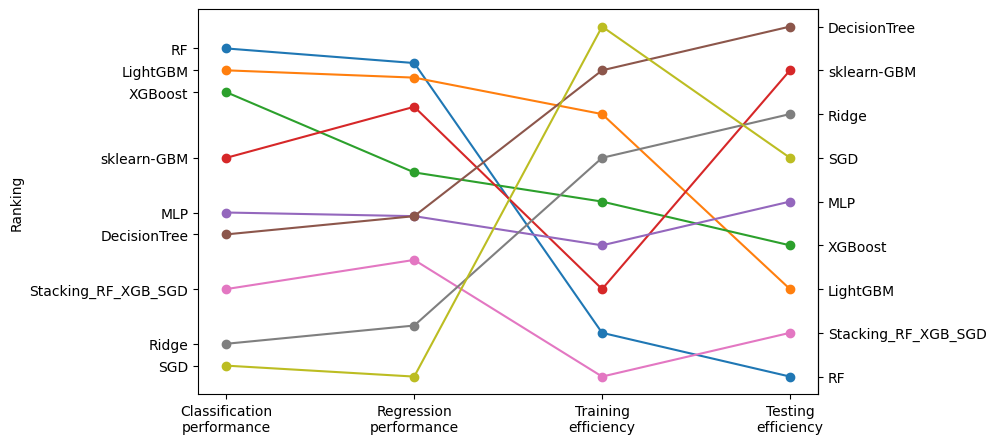

In [48]:
fig, ax = plt.subplots(figsize=(8, 5))
to_plot = pd.concat([ranking_cls, ranking_reg, ranking_time], axis=1).sort_values(by='mean_ranking_cls')
for index, line in to_plot.iterrows():
    ax.plot([1,2,3,4], [line['mean_ranking_cls'], line['mean_ranking_reg'], line['Training_time'], line['Prediction_time']], 'o-')

ax.set_yticks(to_plot['mean_ranking_cls'], list(to_plot.index))
yax2 = ax.secondary_yaxis("right")
yax2.set_yticks(to_plot['Prediction_time'], list(to_plot.index))
ax.set_xticks([1,2,3,4], ['Classification\nperformance', 'Regression\nperformance', 'Training\nefficiency', 'Testing\nefficiency'])
ax.set_ylabel('Ranking')
ax.invert_yaxis()
plt.show()


## Conclusion

An interesting trade-off: base models with good performance tend to be time-consuming. 

For example, although Random Forest (RF) scores the highest for performance, it is the most time consuming (and likely memory consuming) algorithm; 

Ridge and SGD, as mentioned before, are the fastest but have poor modeling performance.

Because the common conduct of using AdaSTEM is to predict on the prediction set, which is the most time-consuming step, the testing/prediction efficiency is very important.

To balance the performance and scalability, `looks like XGBoost, sklearn-GBM, and LightGBM could be the best algorithm for us`.

This is not to say that other algorithm are never suitable – it depends on your goal, resources availability, and time constrain. To some extreme, a dense neural network could also become the base model, if it suits your need.


In [50]:
from watermark import watermark
print(watermark())
print(watermark(packages="stemflow,numpy,scipy,pandas,xgboost,tqdm,matplotlib,h3pandas,geopandas,scikit-learn"))


Last updated: 2024-01-12T19:41:29.000734+08:00

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 8.14.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

stemflow    : 1.0.9.4
numpy       : 1.24.3
scipy       : 1.10.1
pandas      : 2.0.3
xgboost     : 1.7.6
tqdm        : 4.65.0
matplotlib  : 3.7.1
h3pandas    : 0.2.4
geopandas   : 0.11.1
scikit-learn: 0.0

